ChEn-3170: Computational Methods in Chemical Engineering Spring 2020 UMass Lowell; Prof. V. F. de Almeida **03Feb20**

# 07d. Computational Stoichiometry
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
* [Introduction](#intro)
* [Reaction Mechanism Data](#stoicmtrx)
* [Principal Reaction Sub-Mechanisms](#subreact)
---

## [Introduction](#toc)<a id="intro"></a>
Refer to Notebook 7.

## [Reaction Mechanism Data](#toc)<a id="stoicmtrx"></a>
Read reaction mechanism and derive necessary data for analysis.

In [1]:
'''Read and process a water-gas shift reaction mechanism'''

try:
    from chen_3170.toolkit import reaction_mechanism
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

(species, reactions, s_mtrx, _, _) = reaction_mechanism('data/water-gas-shift-rxn.txt')

r0 :  H2O + CO <-> CO2 + H2
r1 :  H2O + H  <-> H2  + OH
r2 :  OH  + CO <-> CO2 + H
n_reactions = 3
['H', 'H2O', 'CO', 'H2', 'CO2', 'OH']
# species = 6

s_mtrx =
 [[ 0. -1. -1.  1.  1.  0.]
 [-1. -1.  0.  1.  0.  1.]
 [ 1.  0. -1.  0.  1. -1.]]
m x n = (3, 6)
matrix shape = (3, 6)


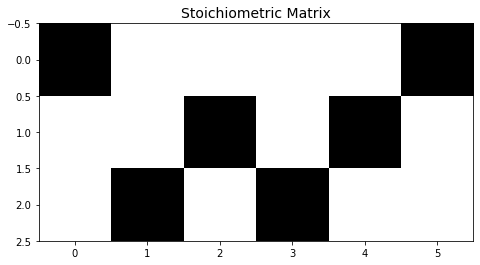

In [2]:
'''Summary'''

from chen_3170.help import print_reactions

print_reactions(reactions)

print(species)  
print('# species =',len(species))
print('')
print('s_mtrx =\n',s_mtrx)
print('m x n =',s_mtrx.shape)

from chen_3170.help import plot_matrix

import numpy as np
np.set_printoptions(precision=3, threshold=300, edgeitems=8, linewidth=100)

plot_matrix(s_mtrx, title='Stoichiometric Matrix')

## [Principal Reaction Sub-Mechanisms](#toc)<a id="subreact"></a>
Principal reaction mechanism(s) analysis.

# reactions =  3
# species   =  6
rank of S =  2
# of all possible sub_mechanisms = 3
# of full-rank sub_mechanisms = 3


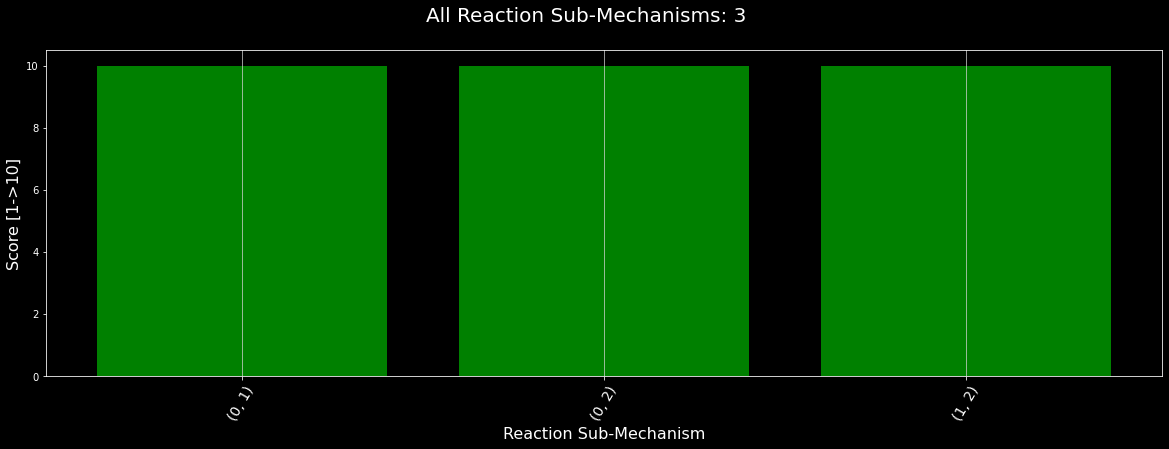

r0 :  H2O + CO <-> CO2 + H2
r1 :  H2O + H  <-> H2  + OH
r2 :  OH  + CO <-> CO2 + H
n_reactions = 3

Reaction Sub Mechanism: 0 (score 10.00)
r0 H2O + CO <-> CO2 + H2
r1 H2O + H  <-> H2  + OH
Reaction Sub Mechanism: 1 (score 10.00)
r0 H2O + CO <-> CO2 + H2
r2 OH  + CO <-> CO2 + H
Reaction Sub Mechanism: 2 (score 10.00)
r1 H2O + H  <-> H2  + OH
r2 OH  + CO <-> CO2 + H


In [3]:
'''2.4 Most relevant reaction sub-mechanisms'''
try:
    from chen_3170.toolkit import sub_mechanisms
    from chen_3170.toolkit import plot_reaction_sub_mechanisms
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

sub_mech = sub_mechanisms(species, reactions, s_mtrx)

plot_reaction_sub_mechanisms(sub_mech, mode='all', style='dark')

print_reactions(reactions)
print('')

from chen_3170.help import print_reaction_sub_mechanisms

print_reaction_sub_mechanisms(sub_mech, mode='top')